In [16]:
from functools import partial
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd

from circuit_sim import circuit_sim

ic_list = [20, 50, 100, 213]
vb_list = [0.50e-3, 2.50e-3]
bc_list = [2]
jj_count_list = [16, 32, 48, 64, 80]
tot_combi = len(ic_list) * len(vb_list) * len(bc_list) * len(jj_count_list)
indices = range(1, tot_combi + 1)

def strParse(index, tot_combi):
    ic_tag = (index - 1) % len(ic_list)
    vb_tag = ((index - 1) // len(ic_list)) % len(vb_list)
    bc_tag = ((index - 1) // (len(ic_list) * len(vb_list))) % len(bc_list)
    jjc_tag = ((index - 1) // (len(ic_list) * len(vb_list) * len(bc_list))) % len(jj_count_list)
    Ic = ic_list[ic_tag]
    vb = vb_list[vb_tag]
    bc = bc_list[bc_tag]
    jj_count = jj_count_list[jjc_tag]
    return vb, bc, Ic, jj_count

def run_simulation(i):
    vb, bc, Ic, jj_count = strParse(i, tot_combi)
    Ic_scale = Ic / 213
    Vb_scale = vb / 2.50e-3
    
    target = "sfq-jtl-axsfq"
    sorce_netlist = target + "-" + str(jj_count) + ".jsm"
    des_dir = "jitter_sfq_" + str(jj_count)

    sim_con = circuit_sim(sorce_netlist)
    sim_con.change_Ic_sfq(Ic_scale)
    sim_con.change_Vb_sfq(Vb_scale)
    sim_con.change_temp(0)
    sim_con.sim()
    index = i % 8
    netlist_file = f"{des_dir}/jitter_{index}.cir"
    sim_con.output_netlist(netlist_file)

    res_start = sim_con.get_switch_timing_sfq(["P(B2|X8|X34)"])
    res_fin = sim_con.get_switch_timing_sfq(["P(B1|X1|X41)"])
    diff1 = res_fin["time"].iloc[0] - res_start["time"].iloc[0]
    per_jj = (diff1-1.775e-12) / (jj_count*2)  # ps per JJ
    return per_jj

In [17]:
if __name__ == "__main__":
    res_df = pd.DataFrame(columns=["Idx","Ic_uA","Vb_mV","Betac","ps_per_JJ","JJ_count"])
    max_workers = int(multiprocessing.cpu_count()/2)
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(run_simulation, i): i for i in indices}
        for future in as_completed(futures):
            index = futures[future]
            try:
                ps_per_JJ = future.result()
                vb, bc, Ic, jj_count = strParse(index, tot_combi)
                res_df = pd.concat([res_df, pd.DataFrame({
                    "Idx": [index],
                    "Ic_uA": [Ic],
                    "Vb_mV": [vb*1e3],
                    "Betac": [bc],
                    "ps_per_JJ": [ps_per_JJ],
                    "JJ_count": [jj_count]
                })], ignore_index=True)
            except Exception as e:
                print(f"Index {index} generated an exception: {e}")
    res_df = res_df.sort_values(by=["Idx"]).reset_index(drop=True)
    print(res_df)

   Idx Ic_uA  Vb_mV Betac     ps_per_JJ JJ_count
0    1    20    0.5     2  2.544531e-12       16
1    2    50    0.5     2  2.544531e-12       16
2    3   100    0.5     2  2.544531e-12       16
3    4   213    0.5     2  2.544531e-12       16
4    5    20    2.5     2  1.778906e-12       16
5    6    50    2.5     2  1.778906e-12       16
6    7   100    2.5     2  1.778906e-12       16
7    8   213    2.5     2  1.778906e-12       16
8    9    20    0.5     2  2.548047e-12       32
9   10    50    0.5     2  2.548047e-12       32
10  11   100    0.5     2  2.548047e-12       32
11  12   213    0.5     2  2.548047e-12       32
12  13    20    2.5     2  1.776953e-12       32
13  14    50    2.5     2  1.776953e-12       32
14  15   100    2.5     2  1.776953e-12       32
15  16   213    2.5     2  1.776953e-12       32
16  17    20    0.5     2  2.549219e-12       48
17  18    50    0.5     2  2.549219e-12       48
18  19   100    0.5     2  2.549219e-12       48
19  20   213    0.5 

/tmp/ipykernel_37713/143198556.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


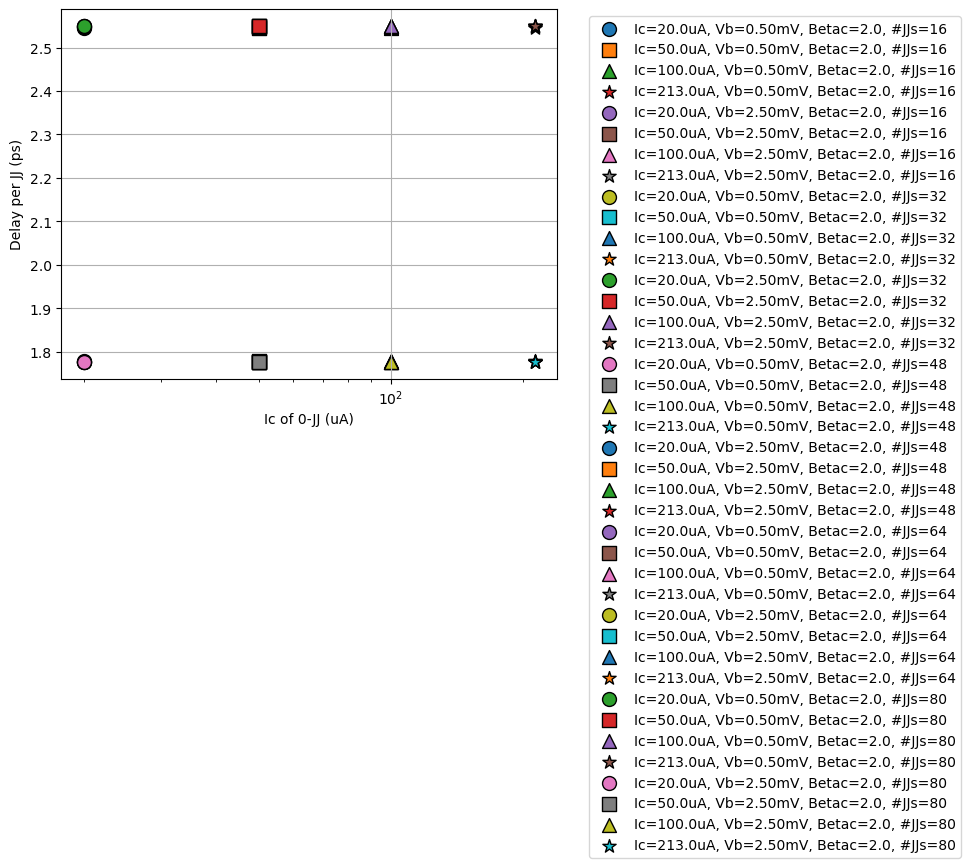

In [18]:
import matplotlib.pyplot as plt

marker_styles = ['o', 's', '^', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# marker_styles = ['o', 's', '^', 'v', '<', '>', 'x', '+', '*', 'D']
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

plt.figure()
for i in range(len(res_df["Idx"])):
    marker_map = i % len(marker_styles)
    # color_map = int(i / int(tot_combi/len(ic_list)))
    Ic = res_df["Ic_uA"].iloc[i]
    Vb = res_df["Vb_mV"].iloc[i]
    Betac = res_df["Betac"].iloc[i]
    delay = res_df["ps_per_JJ"].iloc[i]
    jj_count = res_df["JJ_count"].iloc[i]
    label = f"Ic={Ic:.1f}uA, Vb={Vb:.2f}mV, Betac={Betac:.1f}, #JJs={jj_count}"
    plt.scatter(Ic, delay*1e12, marker=marker_styles[marker_map], label=label, s=100, edgecolors='black')
# plt.xlim(15, 23)
# plt.ylim(3.5, 3.6)
plt.xscale("log")
plt.xlabel("Ic of 0-JJ (uA)")
plt.ylabel("Delay per JJ (ps)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


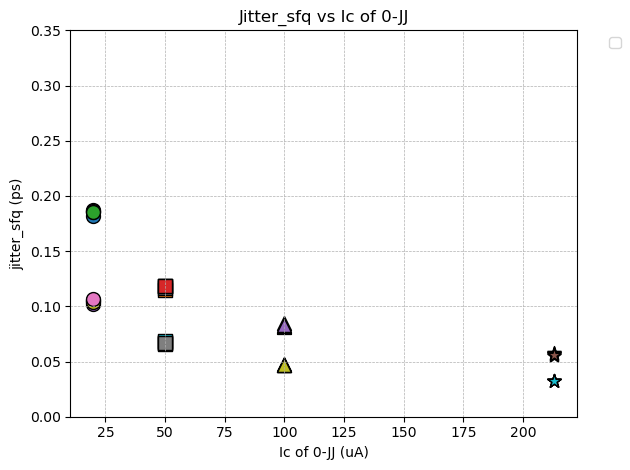

In [26]:
# (2)
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

ic_list = [20, 50, 100, 213]
vb_list = [0.50e-3, 2.50e-3]
bc_list = [2]
jj_count_list = [16, 32, 48, 64, 80]
tot_combi = len(ic_list) * len(vb_list) * len(bc_list) * len(jj_count_list)
indices = range(1, tot_combi + 1)

def strParse(index, tot_combi):
    ic_tag = (index - 1) % len(ic_list)
    vb_tag = ((index - 1) // len(ic_list)) % len(vb_list)
    bc_tag = ((index - 1) // (len(ic_list) * len(vb_list))) % len(bc_list)
    jjc_tag = ((index - 1) // (len(ic_list) * len(vb_list) * len(bc_list))) % len(jj_count_list)
    Ic = ic_list[ic_tag]
    vb = vb_list[vb_tag]
    bc = bc_list[bc_tag]
    jj_count = jj_count_list[jjc_tag]
    return vb, bc, Ic, jj_count

plt.rcParams['font.family'] = ''
xy_data = pd.DataFrame(columns=["Ic", "Vb", "Betac", "Std", "JJ_count"])
for i in indices:
    vb, bc, Ic, jj_count = strParse(i, tot_combi)
    des_dir = "jitter_sfq_" + str(jj_count)
    index = i % 8
    diff_file = des_dir + f"/diff_{index}.csv"
    data = pd.read_csv(diff_file)
    mu, std = norm.fit(data)
    std_per_jj = math.sqrt(std*std/(jj_count*2))
    xy_data = pd.concat([xy_data, 
                        pd.DataFrame([[Ic, vb, bc, std_per_jj, jj_count]],
                        columns=["Ic", "Vb", "Betac", "Std", "JJ_count"])],
                        ignore_index=True)

# print(xy_data)

marker_styles = ['o', 's', '^', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig = plt.figure()
for idx, row in xy_data.iterrows():
    marker_map = idx % len(marker_styles)
    # color_map = int(idx / int(len(xy_data)/len(lic_list)))
    plt.scatter(row["Ic"], row["Std"]*1e12,
                marker=marker_styles[marker_map],
                s=100,
                # color = colors[color_map],
                edgecolors='black',
                alpha=1.0,
                )
    
# plt.xlim(0, 35)
plt.ylim(0, 0.35)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title('Jitter_sfq vs Ic of 0-JJ')
plt.xlabel('Ic of 0-JJ (uA)')
plt.ylabel('jitter_sfq (ps)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.close()